# 
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>



# Comparison of Clustering Methods for Geospatial Data

#### Timur Kuru
#### Petroleum and Geosystems Engineering, Cockrell Schoolof Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

#### Prepared 12/1/2022


_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin

#### Course TA: Midé Mabadeje, Graduate Student, The University of Texas at Austin

## Executive Summary

Clustering weighted geospatial data can be useful for both visualizing a geospatial feature or solving geospatial engineering problem.  We can apply different ML clustering algorithms, each with strengths and weaknesses. In this workflow, we cluster stationary sources of CO2 emissions within the USA to identify potential clusters for future storage "hubs".  We apply KMeans, DBSCAN, and Spectral clustering to the geospatial data, weighted for scale of emissions, and compare the results, visually and using Silhouette Scores.  KMeans produces a respectable solution, especially given geospatial data tends to be Gaussian, but the algorithm can be skewed by having to incorporate all outliers.  DBSCAN is very effective at excluding outliers, but the algorithm can extremely chellenging to tune.  Spectral clustering also produces a good solution, has a similar issue as KMeans with outliers, but there is not and easy intuitive way to incorporate weighting. We would recommend using Silhoutte Scores for both tuning and comparing across clustering algorithms; however, weighting adds a complexity where judgement needs to be applied to the tuning process.  


## Import Packages

In [1]:
import numpy as np                              # ndarrays for gridded data
import pandas as pd                             # DataFrames for tabular data
import matplotlib.pyplot as plt                 # for plotting
#import warnings                                 # not used but useful during debugging
#warnings.filterwarnings('ignore')               # suppress warnings
#import seaborn as sns                           # for matrix scatter plots
from sklearn import metrics                     # Metrics for measuring clustering performance
from sklearn.cluster import k_means             # K-means clustering (NOTE: not KMeans, used in class)
from sklearn.cluster import DBSCAN              # DBSCAN clustering
from sklearn.cluster import SpectralClustering  # Spectral clustering
from sklearn.neighbors import NearestNeighbors  # Nearest Neighbours function to calculate eps hyperparameter

import time                                     # for measuring algorithm CPU time
pi = np.pi                                      # define constant pi

## Workflow Summary - Comparison of Clustering Methods for Geospatial Data
1. Load and clean data
2. Clean and prepare data
3. Initial visualization of raw data
4. KMeans clustering hypertuning: select number of clusters
4. a) Analyze interia
4. b) Analyze silhoutte scores
5. KMeans clustering - visualize unweighted and weighted results
6. DBSCAN clustering hypertuning: determine epsilon and minimum samples
6. a) Plot nearest neighbor to narrow down epsilon
6. b) Analyze silhoutte scores averages by epsilon and minimum sample
6. c) Visualize range of solutions for unwieghted data
6. d) Visualize range of solutions for weighted data
7. Spectral clustering hypertuning: determine number of clusters and gamma for RBF affinity matrix
7. a) Analyze silhoutte score averages by number of clusters and gamma
7. b) Narrow down number of clusters and gamma with specific silhoutte scores
7. c) Visualize range of solutions for unwieghted data
8. Compare final silhoutte scores

### 1. Load and clean data

The following workflow applies the .csv file 'natcarb_sources2013_v1502.csv', a public dataset of major stationary sources of CO2 in the USA and parts of Canada, from the NETL's Carbon Storage Atlas - Fifth Edition, 2015.  This data is downloadable from the NELT's NATCARB viewer 2.0.  The viewer is available [here](https://edx.netl.doe.gov/geocube/#natcarbviewer).  Select "Atlas" filter near top left, and, under "Layers" tab near right, select "Download Layer" icon next to "CO2 Stationary Sources", and then "Extract & Download" the full dataset.

We will work with the following features:

* **longitude** - geographical longitude of the CO2 stationary source
* **latitude** - geographical latitide of the CO2 stationary source
* **co2_tonne** - total annual CO2 emmissions of the stationary source in tonnes

In [2]:
# Load the data from my GitHub repository
my_data = pd.read_csv(r"https://raw.githubusercontent.com/kurutim/PGE383_SubsurfaceML/main/natcarb_sources2013_v1502.csv")
df = my_data.iloc[0:,[5,6,19]]                    # Extract longitude, latitiude, co2 tonnes
df.columns=["Lon","Lat","CO2"]                    # Rename columns for simplicity
df = df.dropna()                                  # Clean by conducting likewise deletion of any incomplete samples
#df.describe()

### 2. Prepare data
Limit geographic scope to continential US for simplicity.
Exclude all emissions sources < 10,000 tonnes per year, to make weighting more meaningful
Limit total samples to 1,000, otherwise visualization gets overwhelming
Apply judgement, and constrain number of clusters to 8 to 25 (this won't apply for DBSCAN, as number of clusters is not a hyperparameter).  Minimum 8 makes sense: conceptually, we should expect at least 2 for the West Coast, at least 4 along the Gulf of Mexico and East Coast, and at least 2 more for the central US.  Max 25 is somewhat arbitrary - but too many clusters and the exercise losing meaning.  
Finally, we nnormalize the data.  Longitude and Latitide are normalized to x and y coordinates on a plane.  CO2 emissions are normalized for weighting.

In [3]:
# Limit scope to continental US and emissions > 10000 tons per year
latMax = 49
latMin = 25
lonMax = -67
lonMin = -125
co2min = 10000
df = df[(df['Lat']>= latMin)&(df['Lat']<= latMax)&(df['Lon']>= lonMin)&(df['Lon']<= lonMax)]
df = df[(df['CO2']>= co2min)]

# Set seed for repeatability and limit sample size to n = 1000 for demonstration
seed = 13
samples = 1000
df = df.sample(n=samples, random_state = seed)

# Constrain max and min clusters based on geographic judgement
clustersMin = 8
clustersMax = 25

In [4]:
# Normalize latitude and longitude to euclidean distance using methodology from Jan van der Vegt
# https://datascience.stackexchange.com/questions/13567/ways-to-deal-with-longitude-latitude-feature/13575#13575
# Ignore z value for simplicity

df['X'] = np.cos(df['Lat']/180*pi) * np.cos(df['Lon']/180*pi)
df['Y'] = np.cos(df['Lat']/180*pi) * np.sin(df['Lon']/180*pi)
#z = sin(lat) 

# Normalize CO2, used for weighting clustering
co2min = df['CO2'].min(); co2max = df['CO2'].max()
df['CO2norm'] = (df['CO2']-co2min)/(co2max - co2min)

### 3. Initial visualization of raw data
Plot the data, including emissions weighting.  We expect, and get, an image that should resemble the outline of the US with emissions correlating to industrial centers.

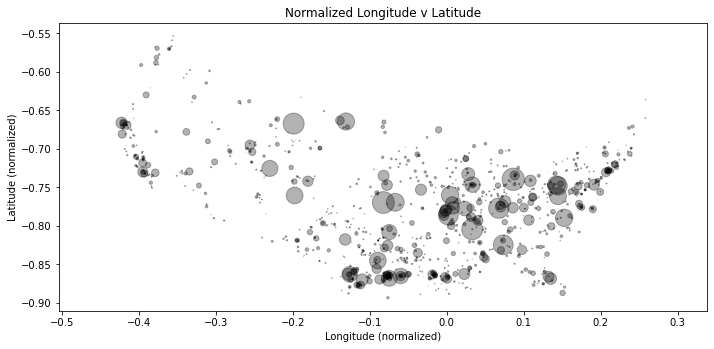

In [5]:
# Visualize data set, including CO2 emissions
xMin = df['X'].min(); xMax = df['X'].max()
yMin = df['Y'].min(); yMax = df['Y'].max()

#plt.subplot(111)
plt.scatter(df['X'],df['Y'],s=df['CO2norm']*500,c="k",alpha = 0.3,linewidths=1.0,edgecolors="k")
plt.title('Normalized Longitude v Latitude'); 
plt.xlabel('Longitude (normalized)'); 
plt.ylabel('Latitude (normalized)')
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)
plt.axis('equal')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.0, wspace=0.2, hspace=0.2)

### 4. KMeans clustering hypertuning: select number of clusters

#### Note on KMeans Clustering
KMeans clustering is an unspervised maching learning algorithm that is given the number of clusters as a hyperparameter, and groups data around centroids.  This algorithm randomly assigns prototypes, assigns closest data points to those prototypes using eculidean distances, and iteratively moves the centroid until the "inertia" of the clusters (effectively the sum of the average of the distances within clusters) is minimized.

#### 4a.
Plot initeria and the change in inertia to help determine optimal number of clusters.  
The results show that a subjective optimal K for the unweighted data set is 10.  Subjective optimal K for the weighted data set is 13.  After these values, change in inertia declines.  

In [6]:
# Determine K-means hyperparameters: number of clusters
# Plot inertia and delta-interia for each incremental cluster

Kmin = clustersMin
Kmax = clustersMax

inertiaK = []
inertiaK_weighted = []
inertiaK_delta = []
inertiaK_weighted_delta = []

last_inertiaK=k_means(df.loc[:,['X','Y']].values,n_clusters=Kmin-1,random_state=seed)[2]
last_inertiaK_weighted=k_means(df.loc[:,['X','Y']].values,n_clusters=Kmin-1,random_state=seed,sample_weight=df['CO2'])[2]

for k in range(Kmin,Kmax+1):
    kmeans = k_means(df.loc[:,['X','Y']].values,n_clusters=k,random_state=seed)
    kmeans_weighted = k_means(df.loc[:,['X','Y']].values,n_clusters=k,random_state=seed,sample_weight=df['CO2'])
    inertiaK.append(kmeans[2])
    inertiaK_weighted.append(kmeans_weighted[2])
    inertiaK_delta.append(last_inertiaK - kmeans[2])
    inertiaK_weighted_delta.append(last_inertiaK_weighted - kmeans_weighted[2])
    last_inertiaK = kmeans[2]
    last_inertiaK_weighted = kmeans_weighted[2]

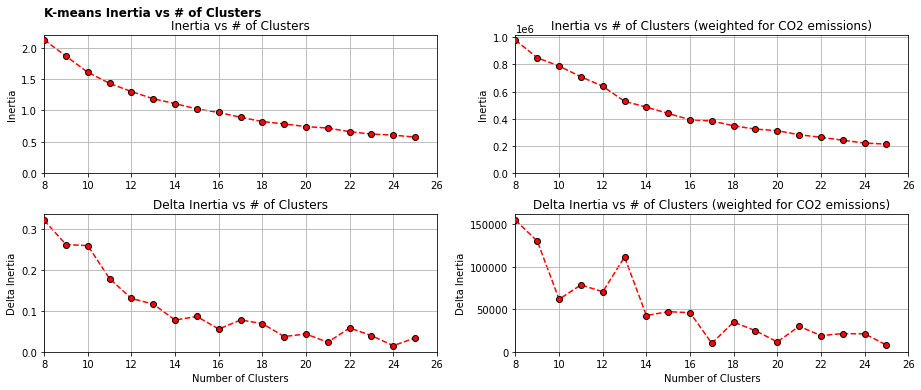

In [7]:
# Plotting code based heavily on code from Prof Michael Prycz 
# https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_clustering.ipynb
plt.subplot(221)
plt.scatter(range(Kmin,Kmax+1),inertiaK,c='red',edgecolor='black',zorder=10)
plt.plot(range(Kmin,Kmax+1),inertiaK,c='red',ls='--',zorder=1)
plt.xlim(Kmin,Kmax+1); plt.ylim(bottom=0); plt.ylabel('Inertia'); plt.grid(True)
plt.title('Inertia vs # of Clusters')

plt.subplot(222)
plt.scatter(range(Kmin,Kmax+1),inertiaK_weighted,c='red',edgecolor='black',zorder=10)
plt.plot(range(Kmin,Kmax+1),inertiaK_weighted,c='red',ls='--',zorder=1)
plt.xlim(Kmin,Kmax+1); plt.ylim(bottom=0); plt.ylabel('Inertia'); plt.grid(True); 
plt.title('Inertia vs # of Clusters (weighted for CO2 emissions)')
                     
plt.subplot(223)
plt.scatter(range(Kmin,Kmax+1),inertiaK_delta,c='red',edgecolor='black',zorder=10)
plt.plot(range(Kmin,Kmax+1),inertiaK_delta,c='red',ls='--',zorder=1)
plt.xlim(Kmin,Kmax+1); plt.ylim(bottom=0); plt.xlabel('Number of Clusters'); plt.ylabel('Delta Inertia'); plt.grid(True)
plt.title('Delta Inertia vs # of Clusters')

plt.subplot(224)
plt.scatter(range(Kmin,Kmax+1),inertiaK_weighted_delta,c='red',edgecolor='black',zorder=10)
plt.plot(range(Kmin,Kmax+1),inertiaK_weighted_delta,c='red',ls='--',zorder=1)
plt.xlim(Kmin,Kmax+1); plt.ylim(bottom=0); plt.xlabel('Number of Clusters'); plt.ylabel('Delta Inertia'); plt.grid(True)
plt.title('Delta Inertia vs # of Clusters (weighted for CO2 emissions)')

plt.suptitle('K-means Inertia vs # of Clusters',x=0,y=1.2,ha='left',fontweight='bold')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.3)
plt.show()

### Step 4 Continued - Analyze silhoutte scores

#### Note on silhoutte scores
There are several different metrics and scores and methods to evaluate clustering performance.  Silhoutte scores were selected for this project.  The silhoutte score is a single metric that is the mean of the silhoutte coefficients for all samples in the data set.  Each coefficient is the calculation, where:

a = the mean distance between the sample and other samples within its cluster

b = the distance between it and all other points in the next nearest cluster

silhouette coefficient = (a - b) /  maximum of a or b

Thus, the score is always a number between -1 and 1, where the higher number indicates tighter clustering.  The advantage of silhoutte scores is they are easy to understand, easy to interpret, and comparable among different clustering methods when the "correct" categorization is not known.  There are two disadvantages to silhoutte scores. 

1. Silhouette scores of convex clusters, such as those produced by KMeans, tend to be higher than density based clusters such as DBSCAN - however, this is a problem across almost all cross-method comparison metrics.
2. Silhoutte scores, in standard form, do not accounting for weighting of samples.  This is a non-trival problem where it is easy to get lost in a rabbit hole.  I was unable to determine a simple methodology for comparing clustering of weighted data, and I concluded it was beyond the scope of this project.  

#### 4b) 
Iterate through silhoutte scores for both the unweighted and weighted data sets to visually determine optimal K's.  The Silouette score for the weighted sample is less meaningful, as the silhouette score does not take account of weighting.  We could not determine an intuitive and simple scoring system for evaluating weighted clusters.  The silhouette scores confirm 10 is the right K value for the unweighted sample, but does not agree with 13 for the weighted.  We decided to stick with K=13 as due to the aforementioned deficiencies of silhoutte scores for weighted data sets.  

In [8]:
# Determine hyperparameter based on silhouette score
silhouetteK = []
silhouetteK_weighted = []

for k in range(Kmin,Kmax+1):
    kmeans = k_means(df.loc[:,['X','Y']].values,n_clusters=k,random_state=seed)
    kmeans_weighted = k_means(df.loc[:,['X','Y']].values,n_clusters=k,random_state=seed,sample_weight=df['CO2'])
    silhouetteK.append(metrics.silhouette_score(df.loc[:,['X','Y']].values,kmeans[1]))
    silhouetteK_weighted.append(metrics.silhouette_score(df.loc[:,['X','Y']].values,kmeans_weighted[1]))


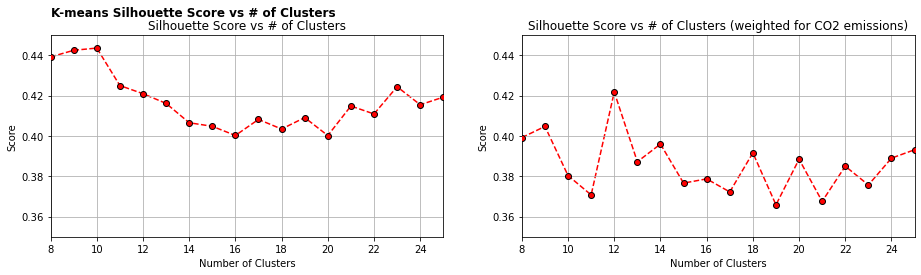

In [9]:
# Plot silhoutte score distributions to determine optimal number of clusters
plt.subplot(121)
plt.scatter(range(Kmin,Kmax+1),silhouetteK,c='red',edgecolor='black',zorder=10)
plt.plot(range(Kmin,Kmax+1), silhouetteK,c='red',ls='--',zorder=1)
plt.xlim(Kmin,Kmax); plt.ylim(0.35,0.45); plt.xlabel('Number of Clusters'); plt.ylabel('Score'); plt.grid(True); 
plt.title('Silhouette Score vs # of Clusters')

plt.subplot(122)
plt.scatter(range(Kmin,Kmax+1),silhouetteK_weighted,c='red',edgecolor='black',zorder=10)
plt.plot(range(Kmin,Kmax+1),silhouetteK_weighted,c='red',ls='--',zorder=1)
plt.xlim(Kmin,Kmax); plt.ylim(0.35,0.45); plt.xlabel('Number of Clusters'); plt.ylabel('Score'); plt.grid(True); 
plt.title('Silhouette Score vs # of Clusters (weighted for CO2 emissions)')

plt.suptitle('K-means Silhouette Score vs # of Clusters',x=0,y=0.8,ha='left',fontweight='bold')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.7, wspace=0.2, hspace=0.2)
plt.show()

### 5. KMeans clustering - visualize weighted and unweighted data
Visually, both models do a good job of clustering the emissions.  We have also plotted the centoids, and they look appropriate. However, subjectively, the weighted clustering and centoids look better positioned around very large emisssions sources.  These are good clustering results.

In [10]:
# Set number of clusters
K = 10
Kweighted = 13

# Calcuate unweighted KMeans and measure CPU time
starttime = time.process_time()
KMeans = k_means(df.loc[:,['X','Y']].values,n_clusters=K,random_state=seed,return_n_iter=True)
df['kMeans'] = kmeans[1]
endtime = time.process_time()
KMeans_time = endtime-starttime

Silhoutte_Matrix =[]
Silhoutte_Matrix.append(['KMeans',metrics.silhouette_score(df.loc[:,['X','Y']].values,kmeans[1])])
# print('CPU Execution time:',KMeans_time, 'seconds')

In [11]:
# Calcuate wieghted KMeans and measure CPU time
starttime = time.process_time()
KMeans_weighted = k_means(df.loc[:,['X','Y']].values,n_clusters=Kweighted,random_state=seed,sample_weight=df['CO2'])
df['kMeans_weighted'] = kmeans_weighted[1]
endtime = time.process_time()
KMeans_weighted_time = endtime-starttime

Silhoutte_Matrix.append(['KMeans weighted',metrics.silhouette_score(df.loc[:,['X','Y']].values,kmeans_weighted[1])])
# print('CPU Execution time:',KMeans_weighted_time, 'seconds')

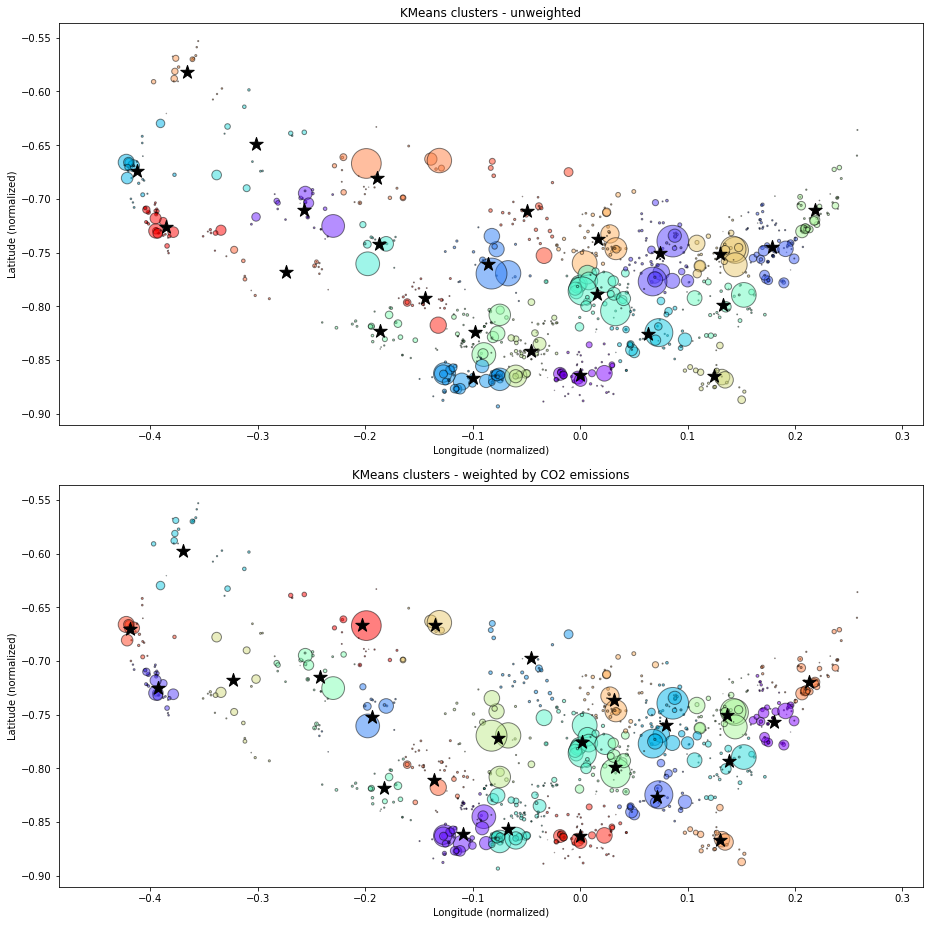

In [12]:
# Plot KMeans & KMeans_weighted clusters
plt.subplot(211)
plt.scatter(df['X'], df['Y'], s=df['CO2norm']*1000, c=df['kMeans'], alpha = 0.5, linewidths=1.0, edgecolors="k", cmap='rainbow')
plt.scatter(kmeans[0][:,[0]],kmeans[0][:,[1]],marker='*',s=200,c='k')
plt.title('KMeans clusters - unweighted'); 
plt.xlabel('Longitude (normalized)'); 
plt.ylabel('Latitude (normalized)')
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)
plt.axis('equal')

plt.subplot(212)
plt.scatter(df['X'], df['Y'], s=df['CO2norm']*1000, c=df['kMeans_weighted'], alpha = 0.5, linewidths=1.0, edgecolors="k", cmap='rainbow')
plt.scatter(kmeans_weighted[0][:,[0]],kmeans_weighted[0][:,[1]],marker='*',s=200,c='k')
plt.title('KMeans clusters - weighted by CO2 emissions'); 
plt.xlabel('Longitude (normalized)'); 
plt.ylabel('Latitude (normalized)')
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)
plt.axis('equal')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3, wspace=0.2, hspace=0.15)
plt.show()

### 6. DBSCAN clustering hypertuning: determine epsilon and minimum samples

#### Note on DBSCAN

DBSCAN is a density based clustering algorithm that has two hyperparameters: epsilon, or the maximum radius of a "neighborhood", and minimum number of samples required to be a cluster.  The algorithm will recurively iterate through the sample determining "core", "border", and "outlier" samples.  The agorithm effectively determines clusters by sample density. It assigning samples to clusters if they are within the maximum radius, and determines outliers if they do not meet max radius and min sample requirements. The advantage of DBSCAN is it does not require a predetermined number of clusters, it can determine cluster shapes that are not convex, and it excludes outliers.  However, DBSCAN is highly sensitive to its hyperparameters, and particular attention must be spent while tuning.  

#### 6a) 
Plot nearest neighbor to narrow down epsilon. Use nearest neighbors function to look for "elbow" to estimate epsilon.  DBSCAN is extremely sensistive to its hyperparameters, so this is a very useful tool to narrow down epsilon. The "elbow" indicates the optimal epsilon value will be somewhere around 0.01 to 0.015, at least for the unweighted data.

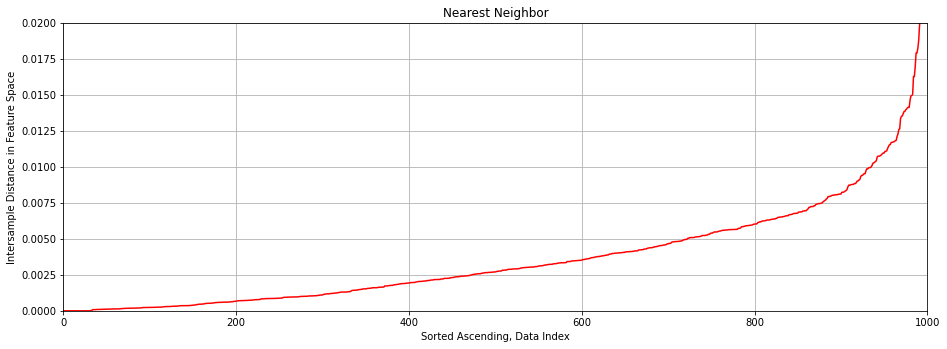

In [13]:
# Determine DBSCAN hyperparameters.  
# Use nearest neighbors function to look for "elbow" to estimate epsilon
# Neighest Neighbors "elbow" code is based heavily on code from Prof Michael Prycz 
# https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_advanced_clustering.ipynb

length = len(df)

nNeighbors = NearestNeighbors(n_neighbors=5,radius=999.0,algorithm='kd_tree')
nNbrs = nNeighbors.fit(df[['X','Y']].values)
distances, indices = nNbrs.kneighbors(df[['X','Y']].values)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances, c = 'red'); plt.grid(True)
plt.xlabel('Sorted Ascending, Data Index')
plt.ylabel('Intersample Distance in Feature Space')
plt.xlim(0,length);plt.ylim(0, 0.02)
plt.title('Nearest Neighbor')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.00, wspace=0.2, hspace=0.2)

### 6b Analyze silhoutte scores averages by epsilon and minimum sample
Loop through a range of eps and min samples, and average their silhoutte scores to help narrow down the optimal hyperparameters.

In [14]:
# Determine DBSCAN hyperparameter using silhoutte scores.
# Loop through range of eps and min_samples, and approximate optimal hyperparamters based on average silhoutte score

DBsilhouette_matrix=[]

min_eps = .01
max_eps = .03
eps_interval = 0.0005
min_minsamp = 3
max_minsamp = 15


for eps in np.arange(min_eps,max_eps,eps_interval):
    for min_samples in range (min_minsamp,max_minsamp):
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(df[['X','Y']].values)
        labels = db.labels_
        score = metrics.silhouette_score(df.loc[:,['X','Y']].values, labels)
        DBsilhouette_matrix.append([eps,min_samples,score])


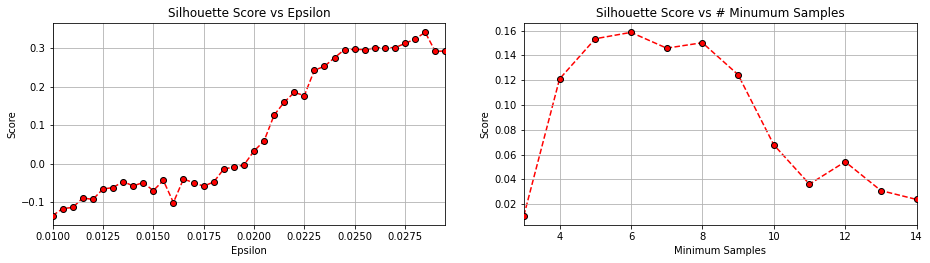

In [15]:
# Plot average silhoutte scores for eps and min_samples
DBsilhouette_matrix=np.array(DBsilhouette_matrix)
xeps=[]
yeps=[]
for eps in np.arange(min_eps,max_eps,eps_interval):
    xeps.append(eps)
    yeps.append(np.mean(DBsilhouette_matrix[:,2],where=(DBsilhouette_matrix[:,0]==eps)))
    
xminsamp = []
yminsamp = []
for min_samples in range (min_minsamp,max_minsamp):
    xminsamp.append(min_samples)
    yminsamp.append(np.mean(DBsilhouette_matrix[:,2],where=(DBsilhouette_matrix[:,1]==min_samples)))

plt.subplot(121)
plt.scatter(xeps,yeps,c='red',edgecolor='black',zorder=10)
plt.plot(xeps,yeps,c='red',ls='--',zorder=1); 
plt.xlim(min_eps,max_eps-eps_interval); plt.xlabel('Epsilon'); plt.ylabel('Score'); plt.grid(True); 
plt.title('Silhouette Score vs Epsilon')

plt.subplot(122)
plt.scatter(xminsamp,yminsamp,c='red',edgecolor='black',zorder=10)
plt.plot(xminsamp,yminsamp,c='red',ls='--',zorder=1)
plt.xlim(min_minsamp,max_minsamp-1); plt.xlabel('Minimum Samples'); plt.ylabel('Score'); plt.grid(True); 
plt.title('Silhouette Score vs # Minumum Samples')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.7, wspace=0.2, hspace=0.2)

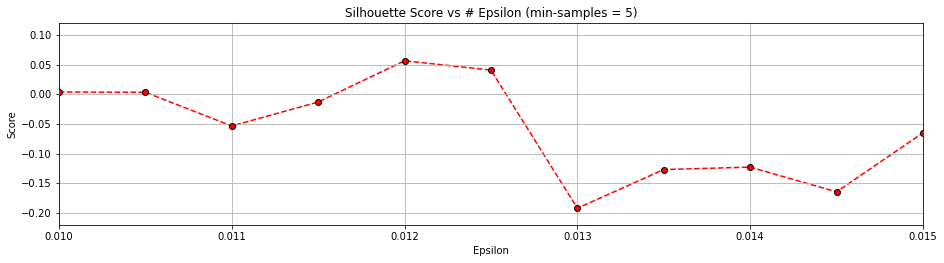

In [16]:
# Optimal eps is high, around 0.028.  However, at this epsilon, the majority of the eastern half of the US 
# is consolidated into a single cluster.  Therefore we need to select a lower epilon score, centered around 
# optimal minimal samples = 5.  
# Determine epsilon silhouette scores at min samples = 5

xminsamp5_silhouette = np.extract(DBsilhouette_matrix[:,1]==5,DBsilhouette_matrix[:,0])
yminsamp5_silhouette = np.extract(DBsilhouette_matrix[:,1]==5,DBsilhouette_matrix[:,2])
plt.scatter(xminsamp5_silhouette,yminsamp5_silhouette,c='red',edgecolor='black',zorder=10)
plt.plot(xminsamp5_silhouette,yminsamp5_silhouette,c='red',ls='--',zorder=1)
plt.xlim(0.01,0.015);plt.ylim(-0.22,0.12);
plt.xlabel('Epsilon'); plt.ylabel('Score'); plt.grid(True); 
plt.title('Silhouette Score vs # Epsilon (min-samples = 5)')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.7, wspace=0.2, hspace=0.2)

### 6c) Visualize range of solutions for unwieghted data
Plot a 3x3 matrix of DBSCANs to identify the final hyperparameters.  Although the silhoutte scores help, the hyperparameters that produce the optimal silhoutte score produces an impractical solution - the epsilon is too high, and the entire eastern half of the country merges into a single cluster.  Other optimizing values produce too high number of clusters. Epsilon of 0.0125 and 5 min samples seems to hit the sweet spot - producing 22 clusters and identifing 13% of the sources as ouliers.  

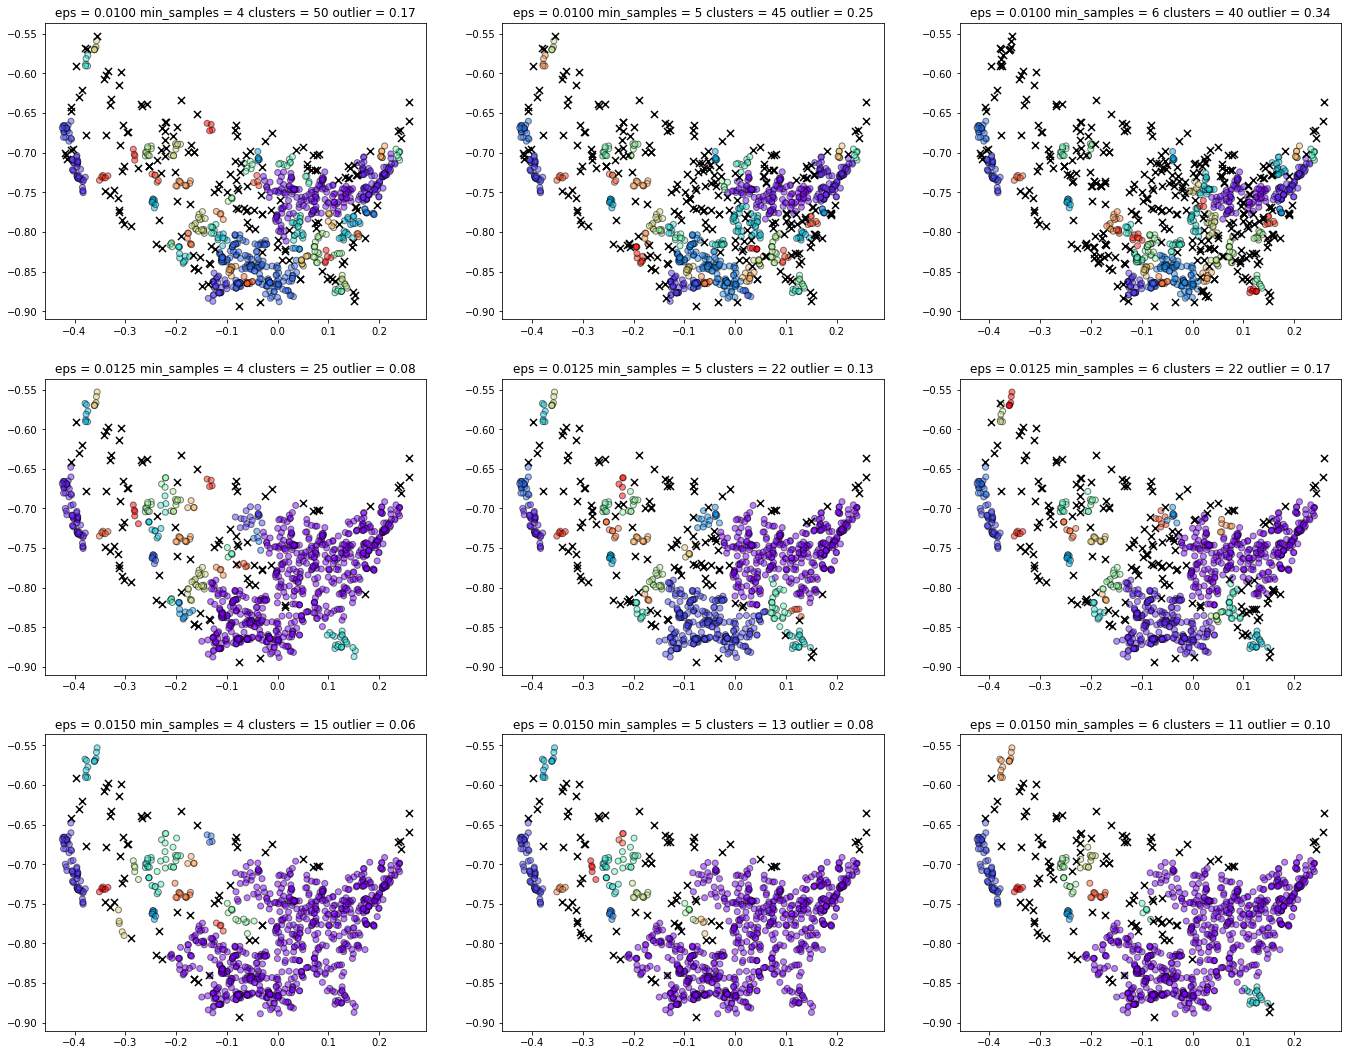

In [17]:
# Plot a 3x3 matrix of DBSCAN outputs around the preferred range to visually evaluate optimal hyperparameters
# Plotting code based heavily on code from Prof Michael Prycz 
# https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_advanced_clustering.ipynb
eps_mat = [0.01,0.0125,0.015] 
min_sample_mat = [4, 5, 6]

index = 1
for eps in eps_mat:
    for min_sample in min_sample_mat:
        db = DBSCAN(eps=eps, min_samples=min_sample).fit(df[['X','Y']].values)
        df['DBSCAN'] = db.labels_ + 1
        n_clusters = len(set(db.labels_))
        plt.subplot(3,3,index)
        df_in = df.loc[(df['DBSCAN'] != 0)]
        plt.scatter(df_in['X'], df_in['Y'], c=df_in['DBSCAN'], alpha=0.5, edgecolor='k', cmap='rainbow')
        df_outlier = df.loc[(df['DBSCAN'] == 0)]
        plt.scatter(df_outlier['X'],df_outlier['Y'],c='k',s = 50,marker = 'x')
        index = index + 1
        plt.title("eps = %0.4f" %eps + " min_samples = %d" %min_sample +
                  " clusters = %d" %n_clusters + " outlier = %0.2f" %(len(df_outlier)/len(df)))
        
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.50, wspace=0.2, hspace=0.2)

In [18]:
db = DBSCAN(eps=0.0125, min_samples=5).fit(df[['X','Y']].values)
labels = db.labels_ + 1
Silhoutte_Matrix.append(['DBSCAN',metrics.silhouette_score(df.loc[:,['X','Y']].values,labels)])

### 6d) Visualize range of solutions for weighted data
Plot a 3x3 matrix of DBSCANs to identify the final hyperparameters.  The silhoutte scores are less meaningful for the weighted data.  Visually, the introduction of weighting shifts the hyperparameters slighly. Epsilon of 0.014 and 5 min samples produces a good result - producing 18 clusters and identifing 14% of the sources as ouliers.  

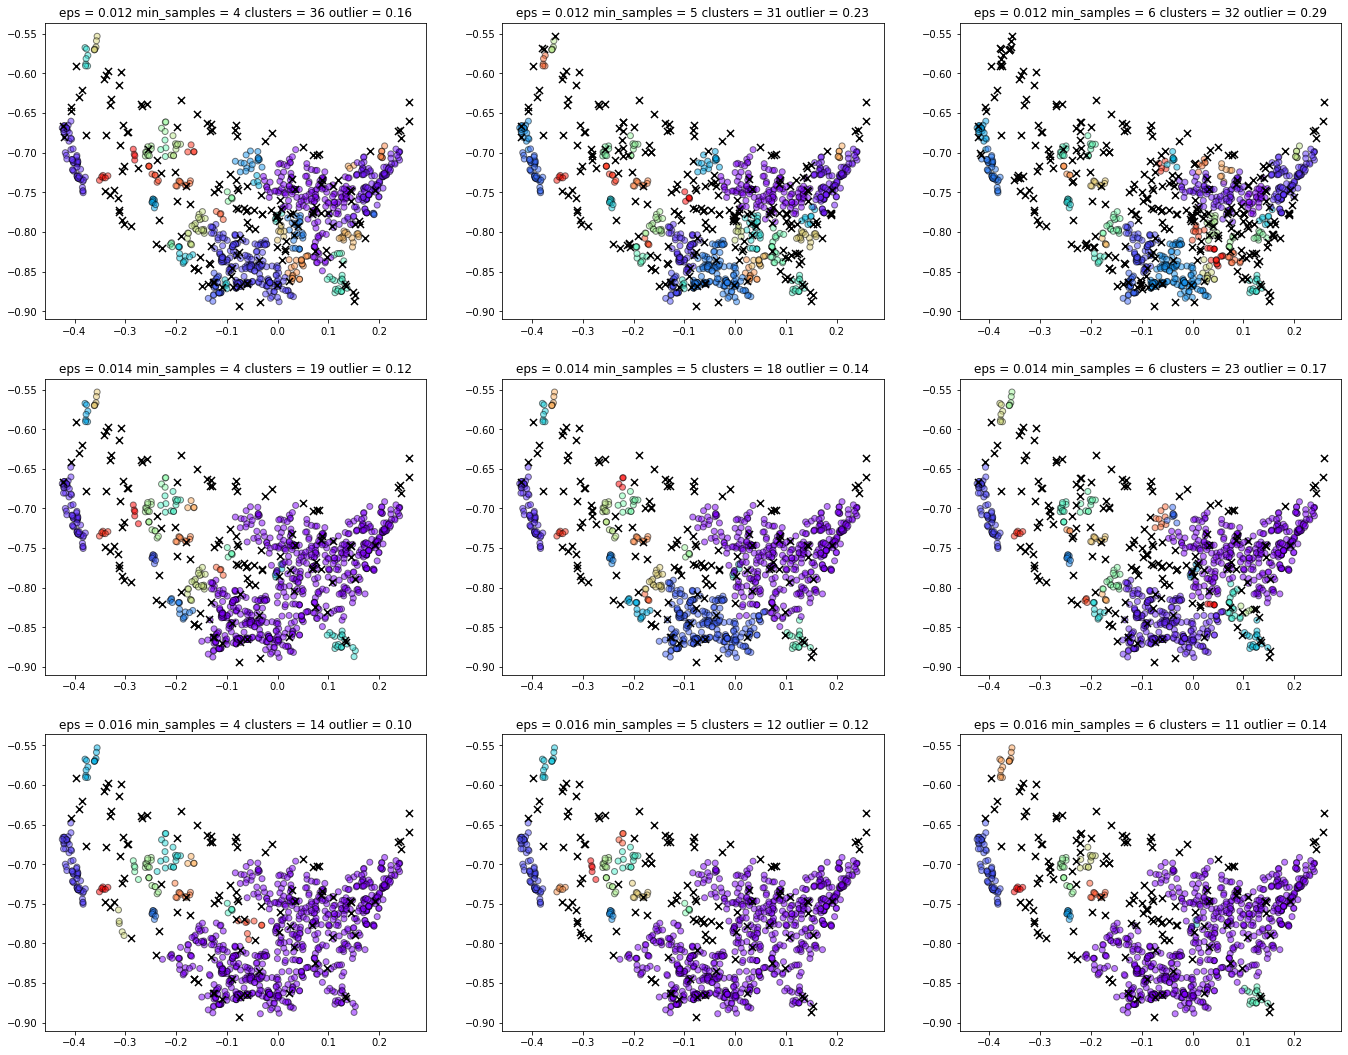

In [19]:
# Plot a 3x3 matrix of weighted DBSCAN outputs around the preferred range to visually evaluate optimal hyperparameters
# Tuning the hyperparameters with weighted DBSCAN is harder.  The weighing effects the min_sample within the algorithm, 
# but my experiments suggest tuning is hyper sensitive to both parameters, and they need to be shifted a little 
# relative to unweighted
eps_mat = [0.012,0.014,0.016] 
min_sample_mat = [4, 5, 6]

# Add a normalized CO2 emissions weighting factor
df['CO2norm_db']=df['CO2norm']*.1

index = 1
for eps in eps_mat:
    for min_sample in min_sample_mat:
        db = DBSCAN(eps=eps, min_samples=min_sample).fit(df[['X','Y','CO2norm_db']].values)
        df['DBSCAN_weighted'] = db.labels_ + 1
        n_clusters = len(set(db.labels_))
        plt.subplot(3,3,index)
        df_in = df.loc[(df['DBSCAN_weighted'] != 0)]
        plt.scatter(df_in['X'], df_in['Y'], c=df_in['DBSCAN_weighted'], alpha=0.5, edgecolor='k', cmap='rainbow')
        df_outlier = df.loc[(df['DBSCAN_weighted'] == 0)]
        plt.scatter(df_outlier['X'],df_outlier['Y'],c='k',s = 50,marker = 'x')
        index = index + 1
        plt.title("eps = %0.3f" %eps + " min_samples = %d" %min_sample +
                  " clusters = %d" %n_clusters + " outlier = %0.2f" %(len(df_outlier)/len(df)))
        
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.50, wspace=0.2, hspace=0.2)

In [20]:
db = DBSCAN(eps=0.014, min_samples=5).fit(df[['X','Y','CO2norm_db']].values)
labels = db.labels_ + 1
Silhoutte_Matrix.append(['DBSCAN weighted',metrics.silhouette_score(df.loc[:,['X','Y']].values,labels)])

### 7. Spectral clustering hypertuning: determine number of clusters and gamma for RBF affinity matrix

#### Note on spectral clustering:

Spectral is an unsupervised clustering algorithm where the sample is transformed into a space represented by the eigenvectors of a similarity matrix.  The samples are then clustered based on the similarities between the samples in the transformed space.  Using eigenvalues and eigenvectors allows for determining the number of clusters (by looking for "jumps" in eigenvalues") and the assignment of clusters results in reduction of dimentionality.  RBF Affinity uses the "radial basis function" to determine affinity between samples, rather than adjecency, in determining the similarity.  

#### 7a) 
Analyze silhoutte score averages by number of clusters and gamma.  Similar to the process with DBSCAN, iterate through a range of hyperparameters to narrow down the values.  We did not attempt Spectral clustering of a weighted model. Setting up the affintity matrix for a weighted data set is not trivial.

In [21]:
# Determine Spectral clustering hyperparameter using silhoutte scores.
# First model uses Radial Based Function to determine affinity matrix.  
# Loop through range of eps and min_samples, and approximate optimal hyperparamters based on average silhoutte score
starttime = time.process_time()

spectral_silhouette_matrix=[]

mincluster = clustersMin
maxcluster = clustersMax
mingamma = 500
maxgamma = 2500
gamma_interval = 250


for nclusters in range(mincluster,maxcluster+1):
    for gamma in range (mingamma,maxgamma+1,gamma_interval):
        spectral = SpectralClustering(n_clusters=nclusters,assign_labels="kmeans",affinity = 'rbf',
                              gamma = gamma,random_state=seed).fit(df[['X','Y']].values)
        labels = spectral.labels_
        score = metrics.silhouette_score(df.loc[:,['X','Y']].values, labels)
        spectral_silhouette_matrix.append([nclusters,gamma,score])

endtime = time.process_time()
print('CPU Execution time:', endtime-starttime, 'seconds')

CPU Execution time: 323.859375 seconds


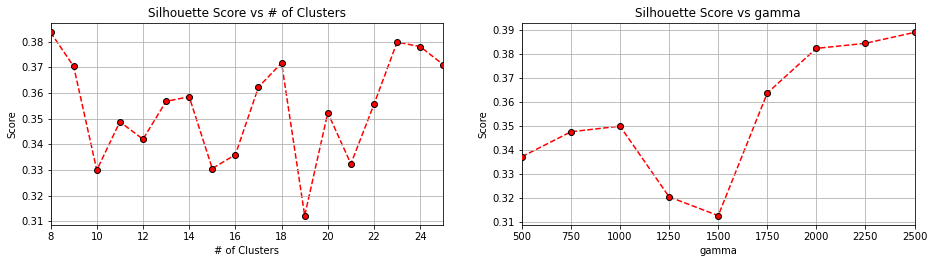

In [22]:
spectral_silhouette_matrix=np.array(spectral_silhouette_matrix)
xNclusters=[]
yNclusters=[]
for nclusters in range(mincluster,maxcluster+1):
    xNclusters.append(nclusters)
    yNclusters.append(np.mean(spectral_silhouette_matrix[:,2],where=(spectral_silhouette_matrix[:,0]==nclusters)))
    
xgamma = []
ygamma = []
for gamma in range (mingamma,maxgamma+1,gamma_interval):
    xgamma.append(gamma)
    ygamma.append(np.mean(spectral_silhouette_matrix[:,2],where=(spectral_silhouette_matrix[:,1]==gamma)))

plt.subplot(121)
plt.scatter(xNclusters,yNclusters,c='red',edgecolor='black',zorder=10)
plt.plot(xNclusters,yNclusters,c='red',ls='--',zorder=1); 
plt.xlim(mincluster,maxcluster); plt.xlabel('# of Clusters'); plt.ylabel('Score'); plt.grid(True); 
plt.title('Silhouette Score vs # of Clusters')

plt.subplot(122)
plt.scatter(xgamma,ygamma,c='red',edgecolor='black',zorder=10)
plt.plot(xgamma,ygamma,c='red',ls='--',zorder=1); 
plt.xlim(mingamma,maxgamma); plt.xlabel('gamma'); plt.ylabel('Score'); plt.grid(True); 
plt.title('Silhouette Score vs gamma')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.7, wspace=0.2, hspace=0.2)

### 7b) Narrow down number of clusters and gamma with specific silhoutte scores
The silhoutte scores did not have an even distribution and had several local peaks.  We narrowed down the number of clusters, and ran the silhoutte scores for gamma at those # of clusters to determine final hyper parameters.  

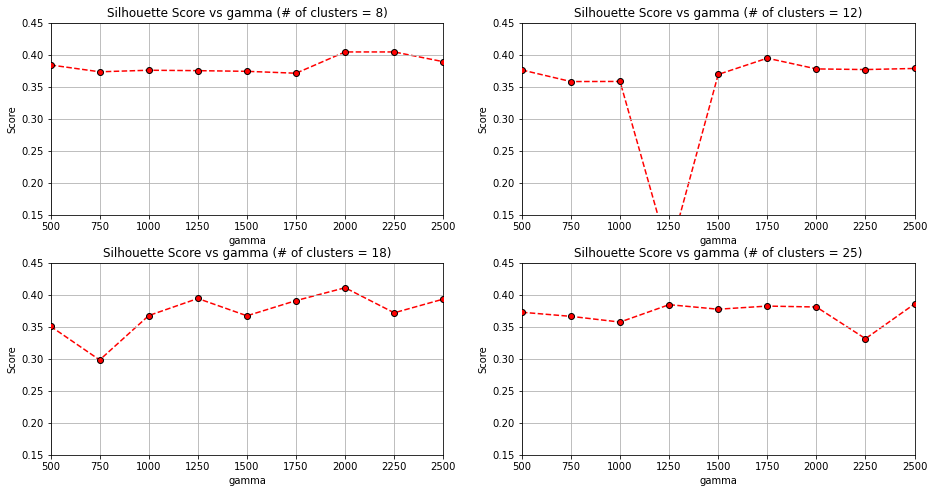

In [23]:
# Siloutte scores are maximized at # of clusters = 8, 12, 18, and 25
# Siloutte scores from gamma have peaks at 750 and 2500
# Determine siloutte scores at # clusters = 8, 12, 18, 25

plt.subplot(221)
x8cluster_silhouette = np.extract(spectral_silhouette_matrix[:,0]==8,spectral_silhouette_matrix[:,1])
y8cluster_silhouette = np.extract(spectral_silhouette_matrix[:,0]==8,spectral_silhouette_matrix[:,2])
plt.scatter(x8cluster_silhouette,y8cluster_silhouette,c='red',edgecolor='black',zorder=10)
plt.plot(x8cluster_silhouette,y8cluster_silhouette,c='red',ls='--',zorder=1); 
plt.xlim(mingamma,maxgamma); plt.ylim(0.15,0.45); plt.xlabel('gamma'); plt.ylabel('Score'); plt.grid(True); 
plt.title('Silhouette Score vs gamma (# of clusters = 8)')

plt.subplot(222)
x12cluster_silhouette = np.extract(spectral_silhouette_matrix[:,0]==12,spectral_silhouette_matrix[:,1])
y12cluster_silhouette = np.extract(spectral_silhouette_matrix[:,0]==12,spectral_silhouette_matrix[:,2])
plt.scatter(x12cluster_silhouette,y12cluster_silhouette,c='red',edgecolor='black',zorder=10)
plt.plot(x12cluster_silhouette,y12cluster_silhouette,c='red',ls='--',zorder=1); 
plt.xlim(mingamma,maxgamma); plt.ylim(0.15,0.45); plt.xlabel('gamma'); plt.ylabel('Score'); plt.grid(True); 
plt.title('Silhouette Score vs gamma (# of clusters = 12)')

plt.subplot(223)
x18cluster_silhouette = np.extract(spectral_silhouette_matrix[:,0]==18,spectral_silhouette_matrix[:,1])
y18cluster_silhouette = np.extract(spectral_silhouette_matrix[:,0]==18,spectral_silhouette_matrix[:,2])
plt.scatter(x18cluster_silhouette,y18cluster_silhouette,c='red',edgecolor='black',zorder=10)
plt.plot(x18cluster_silhouette,y18cluster_silhouette,c='red',ls='--',zorder=1); 
plt.xlim(mingamma,maxgamma); plt.ylim(0.15,0.45); plt.xlabel('gamma'); plt.ylabel('Score'); plt.grid(True); 
plt.title('Silhouette Score vs gamma (# of clusters = 18)')

plt.subplot(224)
x25cluster_silhouette = np.extract(spectral_silhouette_matrix[:,0]==25,spectral_silhouette_matrix[:,1])
y25cluster_silhouette = np.extract(spectral_silhouette_matrix[:,0]==25,spectral_silhouette_matrix[:,2])
plt.scatter(x25cluster_silhouette,y25cluster_silhouette,c='red',edgecolor='black',zorder=10)
plt.plot(x25cluster_silhouette,y25cluster_silhouette,c='red',ls='--',zorder=1); 
plt.xlim(mingamma,maxgamma); plt.ylim(0.15,0.45); plt.xlabel('gamma'); plt.ylabel('Score'); plt.grid(True); 
plt.title('Silhouette Score vs gamma (# of clusters = 25)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.5, wspace=0.2, hspace=0.25)

### 7c) Visualize range of solutions for unwieghted data
Based on the narrowed down silhoutte scores, similar to DBSCAN, we visualized a 3x3 matrix of plots of a range of hypervalues. The plots subjectively confirmed the calculated silhouette values corresponded to the optimal hyperparameters.  We selected 18 as the number of clusters and gamma of 2000.  

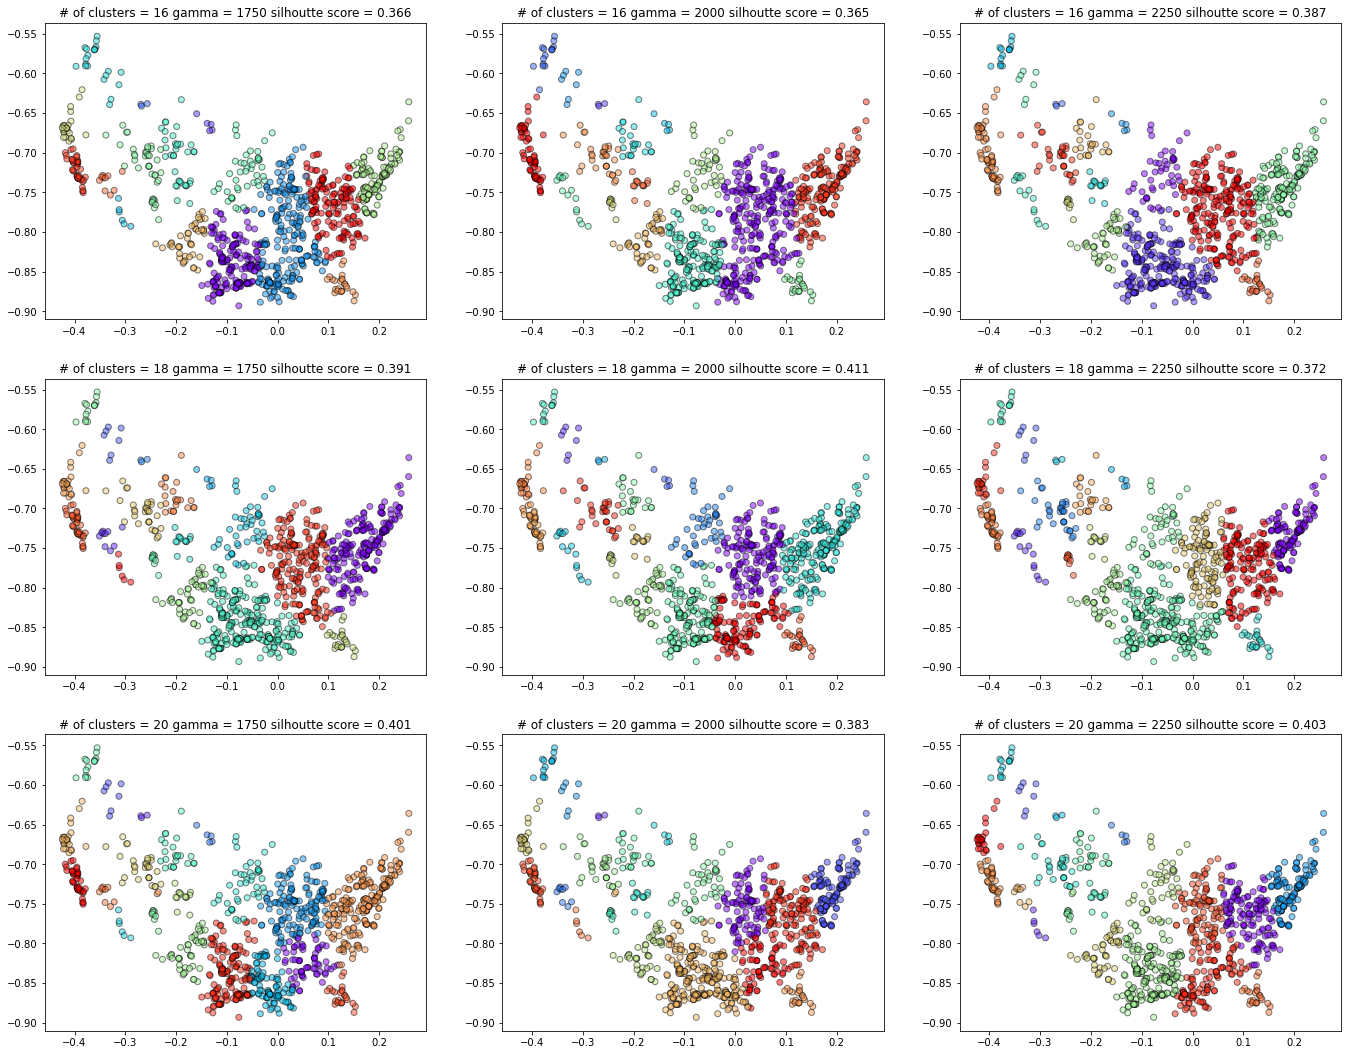

In [24]:
ncluster_mat = [16,18,20] 
gamma_mat = [1750,2000,2250]

index = 1
for ncluster in ncluster_mat:
    for gamma in gamma_mat:
        spectral = SpectralClustering(n_clusters=ncluster,gamma = gamma,
                                      n_neighbors = 200,random_state=seed).fit(df[['X','Y']].values)
        
        labels = spectral.labels_ + 1
        plt.subplot(3,3,index)
        plt.scatter(df['X'], df['Y'], c=labels, alpha=0.5, edgecolor='k', cmap='rainbow')
        score = metrics.silhouette_score(df.loc[:,['X','Y']].values, labels)
        index = index + 1
        plt.title("# of clusters = %d" %ncluster + " gamma = %d" %gamma + " silhoutte score = %0.3f" %score)
        
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.50, wspace=0.2, hspace=0.2)

In [25]:
spectral = SpectralClustering(n_clusters=18,gamma = 2000,n_neighbors = 200,random_state=seed).fit(df[['X','Y']].values)
labels = spectral.labels_ + 1
Silhoutte_Matrix.append(['Spectral',metrics.silhouette_score(df.loc[:,['X','Y']].values,labels)])

### 8. Compare final silhoutte scores and results.
KMeans unweighted had the highest score, but Spectral and DBSCAN were not far behind.  The score for the weighted data sets was less meaningful, but visually the weighted models appeared strong.  

In [29]:
# Print results
# Note: weighted silhoutte results are not very meaningful
Silhoutte_Matrix

[['KMeans', 0.4192713746636149],
 ['KMeans weighted', 0.3931760624058236],
 ['DBSCAN', 0.04093796248048632],
 ['DBSCAN weighted', -0.01929062992701525],
 ['Spectral', 0.41102695732484495]]

### Conclustions and Parting Comments

All three clustering methods have advantages and disadvantages.  However, KMeans clustering is probably most suitable for this particular geospatial clustering exercise, as the data set is simple and related by easily understood euclidean space.  Therefore, using euclidean distances to determine clusters, as KMeans does, is appropriate.  

DBSCAN could possibly have performed better by determining unusual shaped clusters around major geographical features such as mountain ranges and bodies of water; but in this exercise, KMeans did an effective job.  DBSCAN did a better job of excluding outliers; nonetheless, it's key strength of determing optimal number of clusters was less useful for this particular sample, as the number of clusters varied dramatically depending on small changes in hyperparameters.  Such large changes in the number of clusters would not be practical for the real world application of building actual CO2 pipelines and drilling real CO2 injection wells based on these clusters.  

Spectral clustering produced a marginally lower silhouette score for a larger number of clusters when compared to KMeans.  When working in euclidean space, dimensionality reduction is less of an issue, and therefore this was probably not the best suited problem for spectral clustering.  The lower interpretibility of RBF affinity did not provide benefits as it may have with more complicated data set with complex relationships.  Moreover, unlike, KMeans and DBSCAN clustering, there is no straightforward method to incorporate sample weighting into the solution.  Weighting could have possibly been incorporated into the affinity matrix, but this would have further reduced interpretibility; not to mention the volume of emissions of a sample isn't what drives it's similarity to other samples, it's what drives it's importance relative to the sample set overall.  In conclusion,  spectral clustering is probably less appropriate for this geospatial clustering problem.    

Finally, with respect to scoring, the silhouette score was certainly useful in optimizing within methods, and useful comparing across methods.  But once sample weighting was applied, its value became qualitative.  Weighting required the use of good-old-fashioned visualization to determine optimal hyperparameters.  For KMeans, using inertia was also very useful in narrowing down hyperparameters of the weighted data.  A good future exercise would be further research and experimentation to determine a better performance score across weighted clustering methods.  

I hope this was helpful,

Timur Kuru




___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
